In [0]:
# Activate R magic
%load_ext rpy2.ipython

In [0]:
# Problemas com acentuação, consultar este link:
# https://support.rstudio.com/hc/en-us/articles/200532197-Character-Encoding

In [0]:
# Importar imagens
from google.colab import files
from IPython.display import Image

In [0]:
# Configurar o diretório de trabalho
setwd("~/Dropbox/DSA/BigDataAnalytics-R-Azure/Projetos/Mini-Projeto04")
getwd()

**Modelo Preditivo para Análise de Risco de Crédito**

## 1 - Carregar o dataset com **Dados Históricos** em um dataframe

In [79]:
%%R
#.1
credit.df <- read.csv("credit_dataset.csv", header = TRUE, sep = ",")
head(credit.df, 1)

  credit.rating account.balance credit.duration.months
1             1               1                     18
  previous.credit.payment.status credit.purpose credit.amount savings
1                              3              2          1049       1
  employment.duration installment.rate marital.status guarantor
1                   1                4              1         1
  residence.duration current.assets age other.credits apartment.type
1                  4              2  21             2              1
  bank.credits occupation dependents telephone foreign.worker
1            1          3          1         1              1


## 2 - Converter variáveis para tipo Fator (Categórica) 

In [0]:
%%R
#. 2 - Função para converter variáveis para o tipo fator (categórica)
to.factors <- function(df, variables){
  for (variable in variables){
    df[[variable]] <- as.factor(df[[variable]])
  }
  return(df)
}

## 3 - Normalizar dados de diferentes escalas

Ajustar Escalas e aplicar Normalização para que todos os dados estejam dendo de uma Distribuição Normal

In [0]:
%%R
#. 3 - Função equalizar valores na mesma escala de unidade - Normalização
scale.features <- function(df, variables){
  for (variable in variables){
    df[[variable]] <- scale(df[[variable]], center=T, scale=T)
  }
  return(df)
}

## Vetor Numérico

In [0]:
%%R
#. 4 - Criando vetor de valores numéricos "numeric.vars"
numeric.vars <- c("credit.duration.months", "age", "credit.amount")

## Equalizar Escala Numérica

In [26]:
%%R
#. 5- Aplicando escala ao vetor numérico "numeric.vars"
credit.df <- scale.features(credit.df, numeric.vars)
head(credit.df, 3)

  credit.rating account.balance credit.duration.months
1             1               1             -0.2407368
2             1               1             -0.9870788
3             1               2             -0.7382981
  previous.credit.payment.status credit.purpose credit.amount savings
1                              3              2    -0.7872630       1
2                              3              4    -0.1673006       1
3                              2              4    -0.8609500       2
  employment.duration installment.rate marital.status guarantor
1                   1                4              1         1
2                   2                2              3         1
3                   3                2              1         1
  residence.duration current.assets         age other.credits apartment.type
1                  4              2 -1.28093214             2              1
2                  2              1  0.04034293             2              1
3            

##Vetor Categórico

In [0]:
%%R
#. 6 - Criando vetor de valores categóricos "categorical.vars"
categorical.vars <- c('credit.rating', 'account.balance', 'previous.credit.payment.status',
                      'credit.purpose', 'savings', 'employment.duration', 'installment.rate',
                      'marital.status', 'guarantor', 'residence.duration', 'current.assets',
                      'other.credits', 'apartment.type', 'bank.credits', 'occupation', 
                      'dependents', 'telephone', 'foreign.worker')

## Fatorar Categorias

In [28]:
%%R
#. 7 - Aplicando to.factors às variáveis categoricas para tipo fator
credit.df <- to.factors(df = credit.df, variables = categorical.vars)
head(credit.df,3)

  credit.rating account.balance credit.duration.months
1             1               1             -0.2407368
2             1               1             -0.9870788
3             1               2             -0.7382981
  previous.credit.payment.status credit.purpose credit.amount savings
1                              3              2    -0.7872630       1
2                              3              4    -0.1673006       1
3                              2              4    -0.8609500       2
  employment.duration installment.rate marital.status guarantor
1                   1                4              1         1
2                   2                2              3         1
3                   3                2              1         1
  residence.duration current.assets         age other.credits apartment.type
1                  4              2 -1.28093214             2              1
2                  2              1  0.04034293             2              1
3            

##Divisão:

  Dados de Treino para Treinar Modelo

  Dados de Teste para Avaliar Perfomance

In [0]:
%%R
#. 6 - Dividindo os dados em treino e teste - 60:40 ratio
# Cria índice e depois usa o índice para fazer a divisão dentro do conjunto
indexes <- sample(1:nrow(credit.df), size = 0.6 * nrow(credit.df))
# Dados de Treino
train.data <- credit.df[indexes,]
# Dados de Teste
test.data <- credit.df[-indexes,]

## Selecionar Atributos - Feature Selection 

In [0]:
%%R
#. 7 - Feature Selection
install.packages("caret")
install.packageS("randomForest")
library(caret) 
library(randomForest) 

In [0]:
%%R
install.packages("e1071")
library("e1071")

## Criar Função feature.selection() para Seleção de Variáveis

Algumas Variáveis são irrelevantes para a construção do Modelo 

In [0]:
%%R
#. 8 - Função para seleção de variáveis
run.feature.selection <- function(num.iters=20, feature.vars, class.var){
  set.seed(10)
  variable.sizes <- 1:10
  control <- rfeControl(functions = rfFuncs, method = "cv", 
                        verbose = FALSE, returnResamp = "all", 
                        number = num.iters)
  results.rfe <- rfe(x = feature.vars, y = class.var, 
                     sizes = variable.sizes, 
                     rfeControl = control)
  return(results.rfe)
}

## Detectando Variáveis mais Relevantes

In [0]:
%%R
#. 9 - Aplicando a função de seleção de variáveis
rfe.results <- run.feature.selection(feature.vars = train.data[,-1], 
                                     class.var = train.data[,1])


## Imprimir resultado da lista com variáveis mais relevantes

- account.balance
- credit.duration.months
- previus.credit.payment.status
- credi.amount

In [0]:
%%R
#. 10 -  Visualizando os resultados
rfe.results
varImp((rfe.results))

## Criar e Avaliar Modelo

In [0]:
%%R
# Criando e Avaliando o Modelo
install.packages("caret")
install.packages("ROCR")
library(caret) 
library(ROCR) 

# Biblioteca de utilitários para construção de gráficos
source("plot_utils.R") 

In [0]:
%%R
## separate feature and class variables
test.feature.vars <- test.data[,-1]
test.class.var <- test.data[,1]

In [0]:
%%R
# Construindo um modelo de regressão logística
formula.init <- "credit.rating ~ ."
formula.init <- as.formula(formula.init)
lr.model <- glm(formula = formula.init, data = train.data, family = "binomial")

In [60]:
%%R
# Visualizando o modelo
summary(lr.model)


Call:
glm(formula = formula.init, family = "binomial", data = train.data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6933  -0.6446   0.3699   0.6991   2.0383  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      1.31399    1.23154   1.067 0.285993    
account.balance2                 0.37114    0.28951   1.282 0.199846    
account.balance3                 1.32184    0.28564   4.628 3.70e-06 ***
credit.duration.months          -0.47646    0.15769  -3.021 0.002516 ** 
previous.credit.payment.status2  0.99637    0.40422   2.465 0.013704 *  
previous.credit.payment.status3  1.77394    0.43640   4.065 4.81e-05 ***
credit.purpose2                 -1.51441    0.51528  -2.939 0.003293 ** 
credit.purpose3                 -1.61017    0.48580  -3.314 0.000918 ***
credit.purpose4                 -2.02375    0.48065  -4.210 2.55e-05 ***
credit.amount                   -0.26410    0.17890  -1.476 0.1398

In [0]:
%%R
# Testando o modelo nos dados de teste
lr.predictions <- predict(lr.model, test.data, type="response")
lr.predictions <- round(lr.predictions)

In [71]:
%%R
# Avaliando o modelo
confusionMatrix(table(data = lr.predictions, reference = test.class.var), positive = '1')

Confusion Matrix and Statistics

    reference
data   0   1
   0  55  38
   1  69 238
                                          
               Accuracy : 0.7325          
                 95% CI : (0.6863, 0.7753)
    No Information Rate : 0.69            
    P-Value [Acc > NIR] : 0.035911        
                                          
                  Kappa : 0.3285          
                                          
 Mcnemar's Test P-Value : 0.003729        
                                          
            Sensitivity : 0.8623          
            Specificity : 0.4435          
         Pos Pred Value : 0.7752          
         Neg Pred Value : 0.5914          
             Prevalence : 0.6900          
         Detection Rate : 0.5950          
   Detection Prevalence : 0.7675          
      Balanced Accuracy : 0.6529          
                                          
       'Positive' Class : 1               
                                          


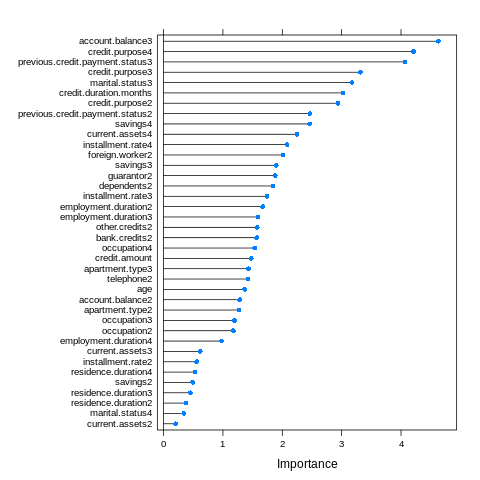

In [72]:
%%R
## Feature selection
formula <- "credit.rating ~ ."
formula <- as.formula(formula)
control <- trainControl(method = "repeatedcv", number = 10, repeats = 2)
model <- train(formula, data = train.data, method = "glm", trControl = control)
importance <- varImp(model, scale = FALSE)
plot(importance)

In [0]:
%%R
# Construindo o modelo com as variáveis selecionadas
formula.new <- "credit.rating ~ account.balance + credit.purpose + previous.credit.payment.status + savings + credit.duration.months"
formula.new <- as.formula(formula.new)
lr.model.new <- glm(formula = formula.new, data = train.data, family = "binomial")

In [74]:
%%R
# Visualizando o modelo
summary(lr.model.new)


Call:
glm(formula = formula.new, family = "binomial", data = train.data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5009  -0.7745   0.4837   0.7453   2.2698  

Coefficients:
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     -0.069028   0.482401  -0.143 0.886216    
account.balance2                 0.329514   0.256490   1.285 0.198896    
account.balance3                 1.267096   0.257166   4.927 8.34e-07 ***
credit.purpose2                 -1.135233   0.445262  -2.550 0.010785 *  
credit.purpose3                 -1.100991   0.411032  -2.679 0.007393 ** 
credit.purpose4                 -1.368591   0.408406  -3.351 0.000805 ***
previous.credit.payment.status2  1.233122   0.340048   3.626 0.000287 ***
previous.credit.payment.status3  1.788379   0.361516   4.947 7.54e-07 ***
savings2                         0.007881   0.326259   0.024 0.980730    
savings3                         0.738078   0.414814   1.

In [0]:
%%R
# Testando o modelo nos dados de teste
lr.predictions.new <- predict(lr.model.new, test.data, type = "response") 
lr.predictions.new <- round(lr.predictions.new)

In [76]:
%%R
# Avaliando o modelo
confusionMatrix(table(data = lr.predictions.new, reference = test.class.var), positive = '1')

Confusion Matrix and Statistics

    reference
data   0   1
   0  43  35
   1  81 241
                                         
               Accuracy : 0.71           
                 95% CI : (0.6628, 0.754)
    No Information Rate : 0.69           
    P-Value [Acc > NIR] : 0.2094         
                                         
                  Kappa : 0.245          
                                         
 Mcnemar's Test P-Value : 2.939e-05      
                                         
            Sensitivity : 0.8732         
            Specificity : 0.3468         
         Pos Pred Value : 0.7484         
         Neg Pred Value : 0.5513         
             Prevalence : 0.6900         
         Detection Rate : 0.6025         
   Detection Prevalence : 0.8050         
      Balanced Accuracy : 0.6100         
                                         
       'Positive' Class : 1              
                                         


## Avaliando a Performance do Modelo

## Curva ROC

A linha vermelha que tudo que estiver abaixo dela tem previsão ruim. Descartada

Acima da linha e mais à esquerda, maior acurácia. 

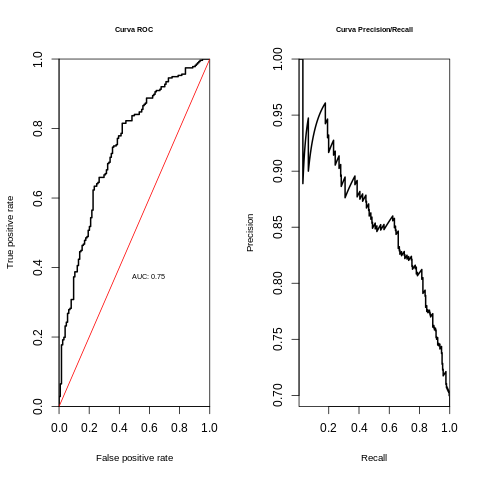

In [77]:
%%R
# Criando curvas ROC
lr.model.best <- lr.model
lr.prediction.values <- predict(lr.model.best, test.feature.vars, type = "response")
predictions <- prediction(lr.prediction.values, test.class.var)
par(mfrow = c(1,2))
plot.roc.curve(predictions, title.text = "Curva ROC")
plot.pr.curve(predictions, title.text = "Curva Precision/Recall")